### Helper Functions for Data Annotation

In [ ]:
def print_words_with_positions(sentence):
    # Split the sentence into words based on spaces
    words = sentence.split()
    # Enumerate the words to get both the index and the word
    indexed_words = [(word, index) for index, word in enumerate(words)]
    # Print each word and its position on a new line
    for word, index in indexed_words:
        print(f"({word}, {index})")

# Example usage
sentence = "the staffs are very friendly , the room while is small , is also very convenient and cozy . it ' s very tidy and the food is good too ^ ^ worth the price and the location is also pretty strategic , just above the mrt station and is quite near to bugis junction too . would come here again to stay for the next visit"
print_words_with_positions(sentence)


In [ ]:
def process_text(input_text, replacements):
    words = input_text.split()
    result = []
    
    for positions, replace_positions, sentiment in replacements:
        new_text = words[:]
        for pos in positions:
            new_text[pos] = "$T$"
        
        replaced_word = words[positions[0]] if len(positions) == 1 else ' '.join([words[pos] for pos in positions])
        
        result.append(" ".join(new_text))
        result.append(replaced_word)
        result.append("Positive" if sentiment == 'POS' else "Negative" if sentiment == 'NEG' else "Neutral")
    
    return result

# Example usage
input_text = ("How can I say that my stay at the MOV Hotel was one of my highlight of my Holidays in Malaysia ? I especially recommend this place not only for the wonderful pool on the roof top and the perfect location but also for the incredible welcoming sense of hospitality of Adam & Mady ")

replacements = [([7], [6], 'POS'), ([20, 21], [35], 'POS')]
output = process_text(input_text, replacements)
for line in output:
    print(line)


***
### Pre-processing Data

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from autocorrect import Speller
from textblob import TextBlob

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize resources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

# Load your dataset
df = pd.read_csv('Americas_Hotel_Reviews_FINAL.csv')

# Function to identify proper nouns
def remove_proper_nouns(tokens):
    tagged = pos_tag(tokens)
    return [word for word, tag in tagged if tag != 'NNP' and tag != 'NNPS']

# Function to convert NLTK POS tags to WordNet POS tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'  # adjective
    elif nltk_tag.startswith('V'):
        return 'v'  # verb
    elif nltk_tag.startswith('N'):
        return 'n'  # noun
    elif nltk_tag.startswith('R'):
        return 'r'  # adverb
    else:
        return None

# Function to correct spelling using TextBlob
def correct_spelling(text):
    blob = TextBlob(text)
    return str(blob.correct())

# Function to clean and preprocess the text
def preprocess_text(text):
    # Correct spelling
    text = correct_spelling(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Remove proper nouns
    tokens = remove_proper_nouns(tokens)
    # Lemmatize each word
    lemmatized_tokens = []
    for word, tag in pos_tag(tokens):
        wn_tag = nltk_tag_to_wordnet_tag(tag)
        if wn_tag is None:
            lemmatized_tokens.append(word)
        else:
            lemmatized_tokens.append(lemmatizer.lemmatize(word, wn_tag))
    return ' '.join(lemmatized_tokens)

# Drop rows with missing review text
df.dropna(subset=['Review Text'], inplace=True)

# Apply preprocessing to the review text
df['Clean Review Text'] = df['Review Text'].apply(preprocess_text)

# Save the preprocessed data
df.to_csv('Americas_Hotel_Reviews_FINAL_clean.csv', index=False)

# Quick preview of the processed data
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


       Area  Rating    Date  \
0  New York       5  Jul-22   
1  New York       5  Dec-23   
2  New York       5  Dec-23   
3  New York       5  Dec-23   
4  New York       5  Dec-23   

                                        Review Title  \
0               Excellent hotel, everything you need   
1                A great place to stay and vacation.   
2  Gorgeous boutique hotel in the perfect locatio...   
3               Hospitable Oasis in Hectic New York!   
4  Absolutely awesome boutique hotel downtown N.Y.C.   

                                         Review Text  \
0  I needed a well priced, downtown hotel near my...   
1  Phenomenal service, especially by Edwyn during...   
2  Perfect location, close to all the excitement ...   
3  Upon arrival we received a heartfelt welcoming...   
4  I absolutely loved my experience at Arlo Soho....   

                                   Clean Review Text  
0  need well price downtown hotel near friend apa...  
1  phenomena service especial

***
## Analysis 1: Volume of Reviews Across Region and Time Period

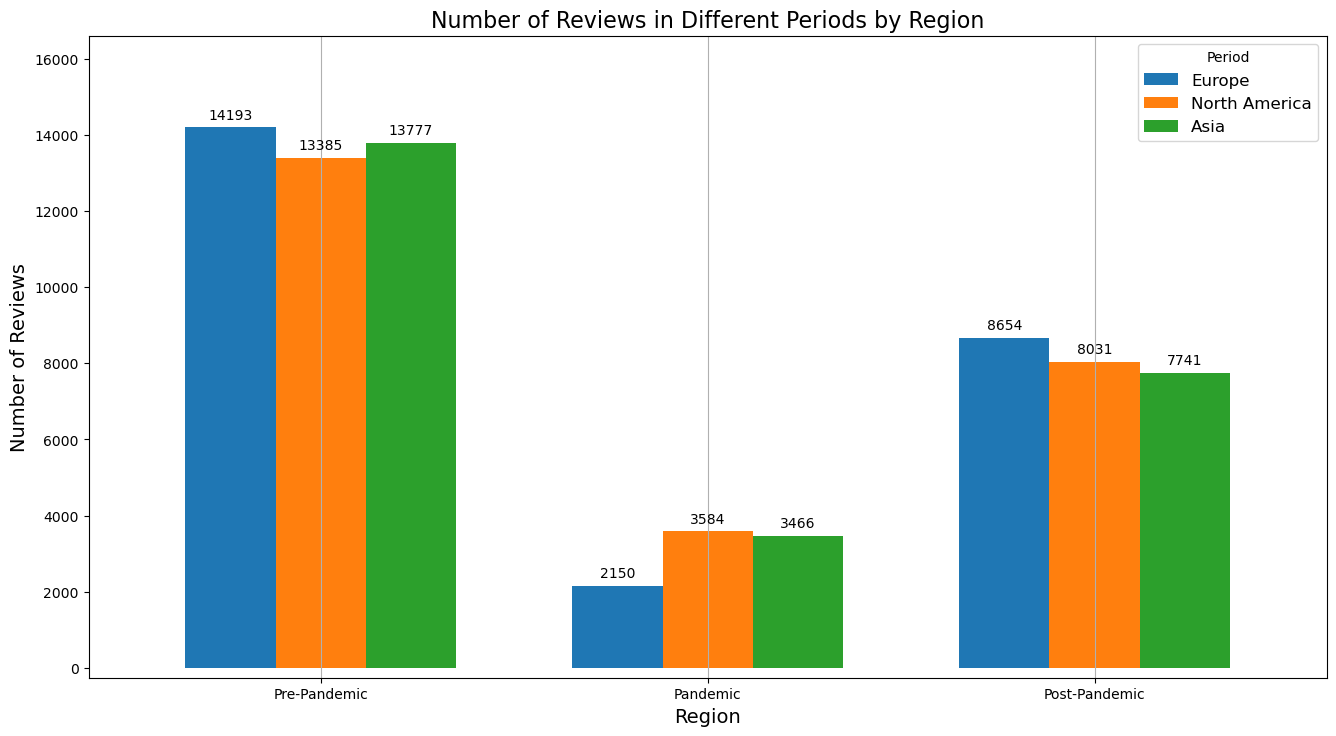

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the data
data = {
    'Period': ['Pre-Pandemic', 'Pandemic', 'Post-Pandemic'] * 3,
    'Region': ['Europe'] * 3 + ['North America'] * 3 + ['Asia'] * 3,
    'Reviews': [14193, 2150, 8654, 13385, 3584, 8031, 13777, 3466, 7741]
}
df = pd.DataFrame(data)
df['Period'] = pd.Categorical(df['Period'], categories=['Pre-Pandemic', 'Pandemic', 'Post-Pandemic'], ordered=True)

# Pivot the data for easier plotting
pivot_data = df.pivot(index='Period', columns='Region', values='Reviews')
pivot_data = pivot_data[['Europe', 'North America', 'Asia']]

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
pivot_data.plot(kind='bar', ax=ax, width=0.7)

# Adjust y-axis scale to exaggerate differences
max_value = pivot_data.values.max()
min_value = pivot_data.values.min()
y_range = max_value - min_value
ax.set_ylim(min_value - y_range * 0.2, max_value + y_range * 0.2)  # add extra space above and below

ax.set_title('Number of Reviews in Different Periods by Region', fontsize=16)
ax.set_xlabel('Region', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)
ax.legend(title='Period', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='x')

# Show values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9),
                textcoords='offset points', fontsize=10, color='black')

# Add whitespace around the chart
plt.tight_layout(pad=3.0)

plt.show()




## Analysis 2: Length of Reviews Comparison by Region and Time

**Objective:** Compare the length of reviews (in words) across different regions and time periods.

1. **Tools:**
    - **Pandas:** For data manipulation.
    - **Matplotlib/Seaborn:** For visualization.
    - **Datetime:** For parsing dates.
2. **Approach:**
    - Calculate the length of each review.
    - Group reviews by region and time period.
    - Visualize results.

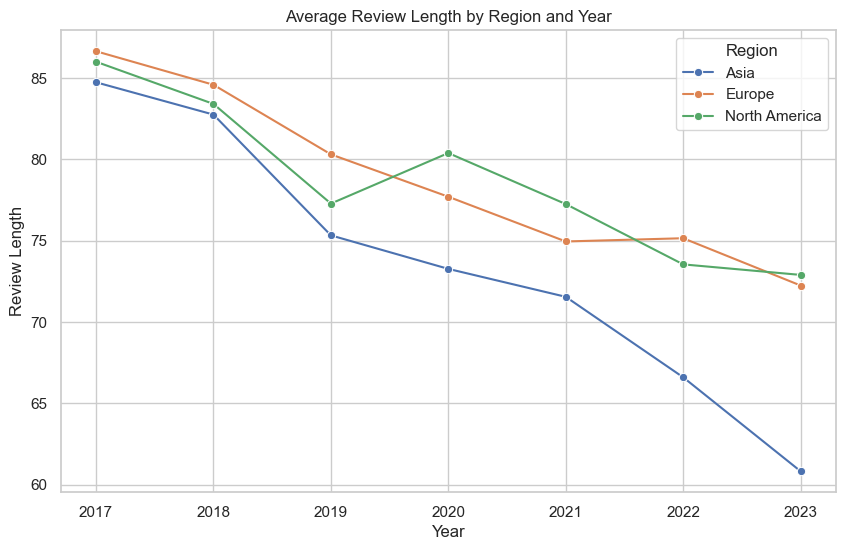

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Hotel_Reviews_FINAL.csv')

# Convert review date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y', errors='coerce')

# Extract the year for grouping
df['Year'] = df['Date'].dt.year

# Calculate review length in words
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x).split()))

# Group by Region and Year
region_time_length = df.groupby(['Region', 'Year'])['Review Length'].mean().reset_index()

# Visualize the comparison
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=region_time_length, x='Year', y='Review Length', hue='Region', marker='o')
plt.title('Average Review Length by Region and Year')
plt.show()


## Analysis 2: Rating of Reviews Comparison by Region and Time

**Objective:** Compare the rating of reviews across regions and time periods.

1. **Tools:**
    - **Pandas**
    - **Matplotlib/Seaborn**
2. **Approach:**
    - Group reviews by region and time period.
    - Aggregate star ratings.
    - Visualize results.

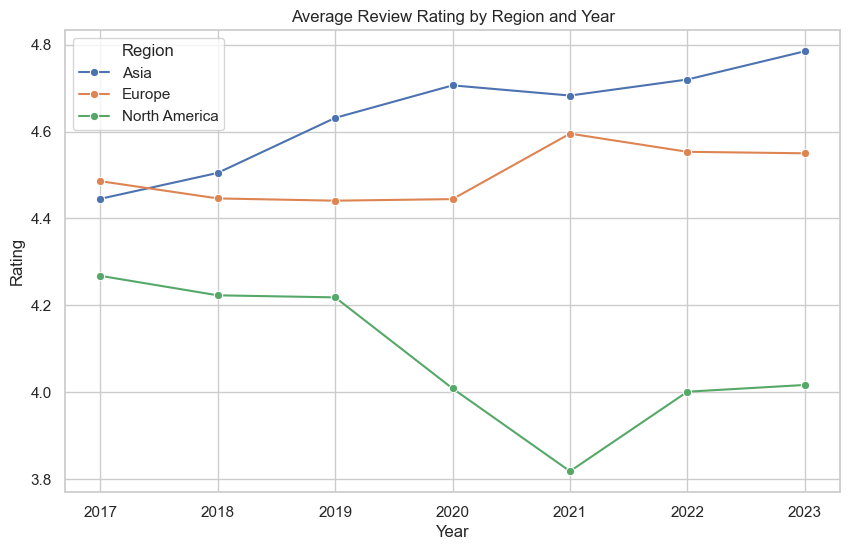

In [12]:
# Group by Region and Year
region_time_rating = df.groupby(['Region', 'Year'])['Rating'].mean().reset_index()

# Visualize the comparison
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=region_time_rating, x='Year', y='Rating', hue='Region', marker='o')
plt.title('Average Review Rating by Region and Year')
plt.show()


## Analysis 3: Correlation Between Review Length and Star Rating
**Objective:** Explore the correlation between review length and star ratings.

1. **Tools:**
   - **Pandas**
   - **Seaborn**

2. **Approach:**
   - Calculate the review length.
   - Plot a bar chart between review length and rating, and compare it by region.
   - Calculate and visualize the correlation.


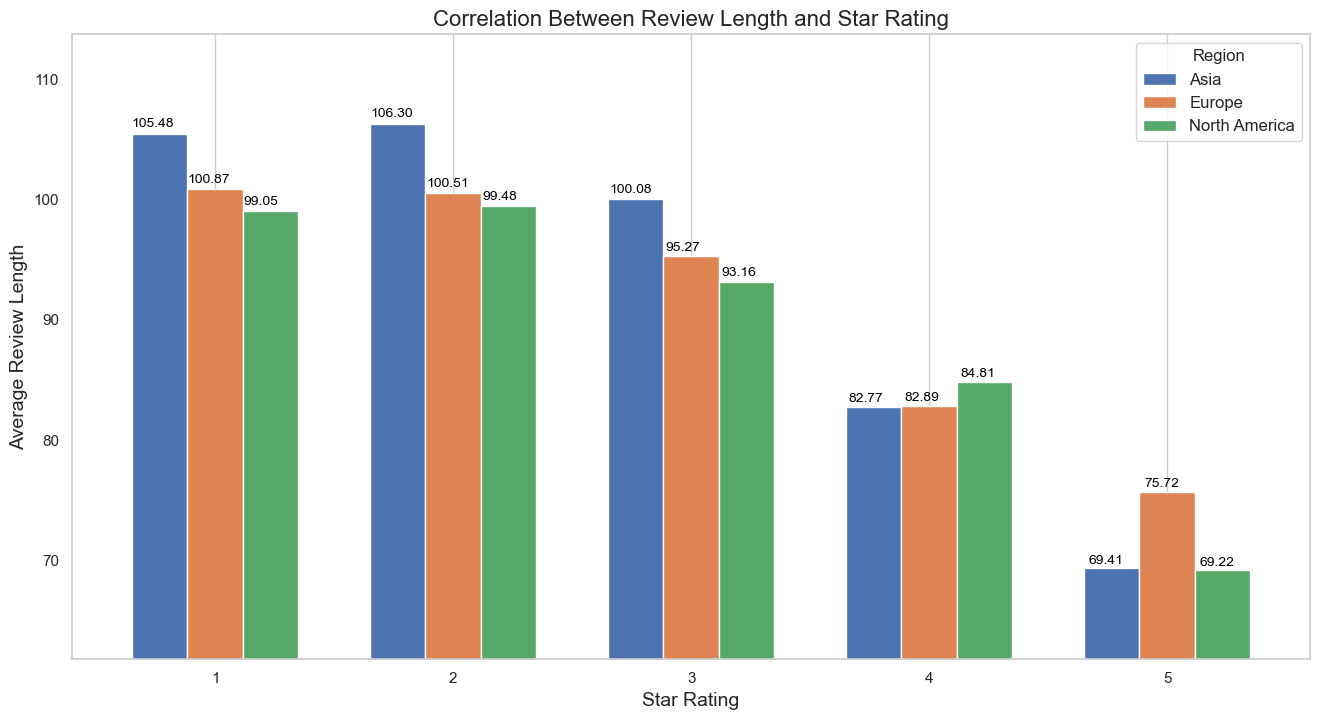

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'Region', 'Rating', and 'Review Text' columns
# Add a new column to calculate the length of each review
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x).split()))

# Aggregate the data
agg_data = df.groupby(['Region', 'Rating'])['Review Length'].mean().reset_index()

# Pivot the data for easier plotting
pivot_data = agg_data.pivot(index='Rating', columns='Region', values='Review Length')

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
pivot_data.plot(kind='bar', ax=ax, width=0.7)

# Adjust y-axis scale to exaggerate differences
max_value = pivot_data.values.max()
min_value = pivot_data.values.min()
y_range = max_value - min_value
ax.set_ylim(min_value - y_range * 0.2, max_value + y_range * 0.2)  # add extra space above and below

ax.set_title('Correlation Between Review Length and Star Rating', fontsize=16)
ax.set_xlabel('Star Rating', fontsize=14)
ax.set_ylabel('Average Review Length', fontsize=14)
ax.legend(title='Region', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y')

# Show values on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=10, color='black')

# Add whitespace around the chart
plt.tight_layout(pad=3.0)

plt.show()


---

## Word2Vec Model and Sentiment Analysis

In [1]:
import pandas as pd
from gensim.models import Word2Vec
from autocorrect import Speller
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the spell checker and lemmatizer
spell = Speller()
lemmatizer = WordNetLemmatizer()


# Function to read and combine review texts from multiple CSV files
def combine_reviews(files):
    combined_reviews = []
    for file_path in files:
        df = pd.read_csv(file_path)
        reviews = df['Review Text'].tolist()
        combined_reviews.extend(reviews)
    return combined_reviews

# Function to preprocess and tokenize reviews
def preprocess_reviews(reviews):
    tokenized_reviews = []
    for review in reviews:
        sentences = sent_tokenize(review)
        for sentence in sentences:
            words = word_tokenize(sentence.lower())
            # words = [spell(lemmatizer.lemmatize(word.lower())) for word in words if word.isalpha()]
            tokenized_reviews.append(words)
    return tokenized_reviews

# Paths to your CSV files
files = [
    'Asia_Hotel_Reviews_FINAL.csv',
    'Europe_Hotel_Reviews_FINAL.csv',
    'Americas_Hotel_Reviews_FINAL.csv'
]

# Combine and preprocess reviews
combined_reviews = combine_reviews(files)
tokenized_reviews = preprocess_reviews(combined_reviews)

# Train the Word2Vec model on the combined and tokenized reviews
model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dini\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
seed_words = {
    'Staff & Service': ['staff', 'service', 'reception', 'concierge', 'manager', 'server', 'waiter', 'waitress', 'receptionist', 'personnel', 'hospitality', 'assistance', 'help', 'friendly', 'polite', 'rude', 'unhelpful', 'attentive', 'responsive', 'professional', 'courteous', 'efficient', 'knowledgeable', 'everybody','welcoming', 'accommodating', 'customer service', 'front desk', 'check-in', 'check-out', 'greet', 'welcome', 'host', 'server', 'secretary', 'owner','servers', 'employee', 'worker', 'workers','hostess', 'bellboy', 'porter', 'housekeeping', 'servicing','maid', 'understaffed', 'bellhop',  'cleaning staff', 'cleaning crew', 'cleaning team', 'housekeeping staff', 'attendant', 'checkin','checkout', 'check in' , 'check out', 'crew', 'team', 'chef', 'janitor', 'maintenance crew', 'maintenance staff', 'maintenance team', 'department','security guard', 'security staff', 'security team', 'reception team', 'reception staff', 'reception crew', 'worker', 'staffed','reception personnel', 'front desk team', 'front desk staff', 'behavior', 'behaviour', 'cashier', 'operator', 'response', 'communication', 'front desk crew', 'front desk personnel', 'man', 'woman', 'lady', 'they', 'he', 'she', 'housekeeper'],
    'Location': ['location', 'access', 'proximity', 'close', 'far', 'near', 'distance', 'convenient', 'central', 'downtown', 'subway', 'metro', 'station', 'metro station', 'bus station', 'bus line', 'walking distance', 'airport', 'in the heart of', 'situated', 'bus', 'public transport', 'suburb', 'neighbor hood', 'neighbourhood','tourist attractions', 'landmarks', 'city','neighborhood', 'area', 'district', 'position', 'located', 'tram'],
    'Facilities': ['pool', 'gym', 'wifi', 'amenities','spa','parking','terrace','bar','rooftop','lounge', 'terrace', 'bakery', 'gift shop', 'fitness center', 'casino', 'communal space', 'sauna', 'steam room', 'garden', 'parking', 'conference room', 'meeting room', 'rooftop bar', 'skybar', 'sky bar', 'rooftop pool', 'swimmingpool','rooftop terrace', 'pool area', 'jacuzzi', 'hot tub', 'cafe', 'elevator', 'corridor', 'hallway', 'wi fi', 'wi-fi', 'internet', 'connection', 'wireless', 'connection', 'broadband', 'connection', 'internet access', 'internet connection', 'internet service', 'internet speed', 'internet quality', 'signal', 'café'],
    'Food & Drink': ['food', 'breakfast', 'dinner', 'restaurant','delicious','tasty','buffet','menu','dining', 'eat', 'drink', 'cuisine', 'beverage', 'coffee', 'tea', 'cocktail', 'wine', 'salad', 'pastry', 'cheese', 'breakfasts', 'seafood', 'dessert', 'snack', 'lunch', 'dining options', 'dine', 'diner', 'dishes', 'drinks', 'beverages', 'cocktails', 'wines', 'juices', 'smoothies', 'alcohol', 'beer', 'liquor', 'spirits', 'bar snacks', 'buffet breakfast', 'buffet dinner', 'buffet lunch', 'buffet spread', 'buffet selection', 'buffet variety', 'buffet options', 'buffet menu', 'buffet food', 'buffet experience', 'buffet quality', 'buffet variety', 'buffet selection', 'buffet assortment', 'buffet display', 'vegetable','buffet presentation', 'fish', 'oysters', 'meat', 'beef', 'steak', 'pancakes', 'bread', 'tiramisu'],
    'Cleanliness & COVID': ['clean', 'hygiene', 'sanitary', 'tidy', 'dirty', 'gross', 'smell', 'dust', 'stain', 'covid', 'virus', 'cleaning', 'sanitize', 'mask', 'odor', 'odour','spotless', 'hand sanitiser', 'COVID measures', 'social distancing','sanitization', 'disinfect', 'sterilize', 'cleanliness', 'gloves', 'restrictions', 'disgusting', 'immaculate', 'neat', 'spotless', 'tidiness', 'cleaning standards', 'cleaning protocols', 'sanitation measures', 'sanitation', 'measures' , 'cleaning practices', 'cleaning procedures', 'cleaning routines', 'hygenic','cleaning service', 'cleanly', 'cleaning process'],
    'Value for Money': ['affordable', 'cheap', 'value', 'price', 'expensive', 'money', 'budget', 'overpriced', 'reasonable', 'deal', 'bargain', 'free', 'voucher', 'discount', 'cost', 'refund', 'pay', 'charge', 'rate', 'fee', 'upgrade', 'worth', 'complimentary', 'discounts', 'deals', 'offers', 'promotion', 'overcharged', 'overcharge', 'promotions','savings', 'economical', 'packages', 'rates', 'fees', 'pricing', 'costs', 'expenses', 'value offering', 'bill', 'billing','value package', 'value deal', 'value experience', 'value for money'],
    'Comfort & Amenities': ['bed', 'room', 'suite', 'toilet','loft', 'bedroom', 'kitchenette', 'apartment','comfort', 'spacious', 'quiet', 'noisy', 'relaxing', 'cosy', 'toiletry', 'cozy', 'A/C', 'view', 'bathroom', 'dark', 'temperature', 'sleep', 'soundproof', 'accommodation', 'shower', 'bathtub', 'pillow', 'towel', 'toiletries', 'robe', 'slippers', 'minibar', 'TV', 'kitchen', 'commodities', 'balcony', 'window', 'curtain', 'lighting', 'amenities', 'features', 'microwave', 'fridge', 'refrigerator', 'wardrobe', 'closet', 'iron', 'soap', 'shampoo','hairdryer', 'hair dryer', 'mirror','chair', 'sofa', 'lamp', 'light', 'fan', 'heater', 'air conditioning', 'air conditioner', 'airconditioned', 'heating', 'cooling', 'ventilation', 'windows', 'balconies', 'views', 'noises', 'noise'],
    'Design & Maintenance': ['hotel', 'beautiful', 'design', 'modern', 'stylish', 'vintage', 'old', 'new', 'maintenance', 'broken', 'fix', 'repair', 'renovate', 'update', 'outdated', 'decor', 'furniture', 'atmosphere', 'interior', 'well-kept', 'lovely', 'gorgeous', 'decoration', 'setting', 'faulty', 'ambiance', 'outdated', 'dated', 'modernize', 'renovation', 'refurbishment', 'restoration', 'upkeep', 'well-maintained' 'condition', 'appearance', 'aesthetics', 'style', 'look', 'feel', 'vibe', 'ambience', 'mood', 'tone', 'aura', 'character', 'charm', 'finishing', 'furnishings', 'fixtures', 'fittings', 'decorations', 'ornaments', 'artwork'],
    'Sustainability': ['sustainable', 'eco-friendly', 'green', 'environment', 'environmental', 'recycle', 'reuse', 'go green', 'carbon', 'eco-conscious', 'sustainability', 'eco']
}

In [53]:
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
from collections import defaultdict


spell = Speller()
lemmatizer = WordNetLemmatizer()

df = pd.read_csv('asia_hotel_reviews_with_aspects_sample_2022.csv')

# Function to map aspect words to their categories using seed words, and expand using Word2Vec if not found
def map_aspect_to_category(aspect, seed_words, model):
    aspect = spell(aspect.lower())
    aspect = lemmatizer.lemmatize(aspect)

    for category, words in seed_words.items():
        if aspect in words:
            return category
        
    # Handle multi-word expressions by splitting and checking each word
    words = aspect.split()
    if len(words) > 1:
        for word in words:
            category = map_aspect_to_category(word, seed_words, model)
            if category != 'Other':
                return category
    # Check using Word2Vec for similar words
    if aspect in model.wv:
        similar_words = model.wv.most_similar(aspect, topn=50)
        for word, _ in similar_words:
            for category, words in seed_words.items():
                if word in words:
                    return category

    # Fallback category
    return 'Other'


# Initialize counters for positive and negative mentions for each aspect category
aspect_counts = defaultdict(lambda: {'Positive': 0, 'Negative': 0, 'Neutral': 0})

# Iterate through the reviews
for index, row in df.iterrows():
    aspects = eval(row['Aspect-Sentiment'])  # Ensure 'Aspect-Sentiment' column is a list of dictionaries
    for aspect, sentiment in zip(aspects['aspect'], aspects['sentiment']):
        category = map_aspect_to_category(aspect, seed_words, model)
        if sentiment == 'Positive':
            aspect_counts[category]['Positive'] += 1
        elif sentiment == 'Negative':
            aspect_counts[category]['Negative'] += 1
        elif sentiment == 'Neutral':
            aspect_counts[category]['Neutral'] += 1

print(aspect_counts)

total_reviews = len(df)
proportion_counts = {category: {sentiment: round((count / total_reviews) * 100, 3) 
                                for sentiment, count in sentiments.items()} 
                     for category, sentiments in aspect_counts.items()}

print(proportion_counts)

defaultdict(<function <lambda> at 0x00000245A3AAFCA0>, {'Design & Maintenance': {'Positive': 414, 'Negative': 35, 'Neutral': 0}, 'Staff & Service': {'Positive': 3357, 'Negative': 142, 'Neutral': 0}, 'Facilities': {'Positive': 601, 'Negative': 59, 'Neutral': 0}, 'Comfort & Amenities': {'Positive': 1283, 'Negative': 149, 'Neutral': 0}, 'Location': {'Positive': 571, 'Negative': 17, 'Neutral': 0}, 'Cleanliness & COVID': {'Positive': 551, 'Negative': 48, 'Neutral': 0}, 'Other': {'Positive': 674, 'Negative': 54, 'Neutral': 0}, 'Value for Money': {'Positive': 203, 'Negative': 47, 'Neutral': 0}, 'Food & Drink': {'Positive': 1465, 'Negative': 129, 'Neutral': 2}, 'Sustainability': {'Positive': 45, 'Negative': 0, 'Neutral': 0}})
{'Design & Maintenance': {'Positive': 14.4, 'Negative': 1.217, 'Neutral': 0.0}, 'Staff & Service': {'Positive': 116.765, 'Negative': 4.939, 'Neutral': 0.0}, 'Facilities': {'Positive': 20.904, 'Negative': 2.052, 'Neutral': 0.0}, 'Comfort & Amenities': {'Positive': 44.626, 

In [58]:
import pandas as pd

# Load the CSV file
file_path = 'asia_hotel_reviews_with_aspects_sample.csv'  # Replace with the path to your CSV file
reviews = pd.read_csv(file_path)

# Ensure the review_date column is in datetime format
reviews['review_date'] = pd.to_datetime(reviews['Date'], errors='coerce')

# Define the date ranges for each period
pre_pandemic = (reviews['review_date'] >= '2017-01-01') & (reviews['review_date'] <= '2019-12-31')
pandemic = (reviews['review_date'] >= '2020-01-01') & (reviews['review_date'] <= '2021-12-31')
post_pandemic = (reviews['review_date'] >= '2022-01-01') & (reviews['review_date'] <= '2023-12-31')

# Count the number of reviews in each period
pre_pandemic_count = reviews[pre_pandemic].shape[0]
pandemic_count = reviews[pandemic].shape[0]
post_pandemic_count = reviews[post_pandemic].shape[0]

# Print the results
print(f'Pre-Pandemic (2017-2019): {pre_pandemic_count} reviews')
print(f'Pandemic (2020-2021): {pandemic_count} reviews')
print(f'Post-Pandemic (2022-2023): {post_pandemic_count} reviews')


Pre-Pandemic (2017-2019): 13777 reviews
Pandemic (2020-2021): 3466 reviews
Post-Pandemic (2022-2023): 7741 reviews
